<a href="https://colab.research.google.com/github/smarulandas/Teoria_Aprendizaje_De_Maquina_-Machine_Learning-/blob/main/CLASIFICADORES_CLASICOS_1_TALLER_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Clasificadores clasicos**

##**1. Naive Bayes Gaussiano**

Es un clasificador supervisado **probabilístico** basado en el **teorema de Bayes**, con una suposición de independencia **"naive"** entre las características, y una suposición adicional de que cada característica $X_i$ sigue una **distribución normal** dentro de cada clase $C_k$.

---

## Modelo

Dado un conjunto de datos con:

- Un vector de características $X = (X_1, X_2, ..., X_n)$
- Una variable de clase $y \in \{ C_1, C_2, ..., C_k \}$

Se quiere predecir la clase más probable, y dado $x$:

$$
\hat{y} = \arg\max_{C_k} P(C_k | X)
$$

Por el **teorema de Bayes**:

$$
P(C_k | X) = \frac{P(X | C_k) \cdot P(C_k)}{P(X)}
$$

Como $P(X)$ es común para todas las clases, basta con **maximizar el numerador**:

$$
\hat{y} = \arg\max_{C_k} P(X | C_k) \cdot P(C_k)
$$

---

## Suposición de Independencia

Con la suposición *naive* de independencia condicional entre características:

$$
P(X | C_k) = P(X_1, X_2, ..., X_n | C_k) = \prod_{i=1}^{n} P(X_i | C_k)
$$

---

## Suposición Gaussiana

Bajo la suposición gaussiana, cada característica $X_i$ **condicional a la clase $C_k$** sigue una distribución normal:

$$
P(X_i | C_k) = \frac{1}{\sqrt{2\pi \sigma_{ik}^2}} \exp\left( - \frac{(X_i - \mu_{ik})^2}{2\sigma_{ik}^2} \right)
$$

Donde:

- $\mu_{ik}$: media de la característica $X_i$ en la clase $C_k$
- $\sigma_{ik}^2$: varianza de $X_i$ en la clase $C_k$

---

## Estimación Cerrada de Parámetros

### Probabilidad a priori de cada clase:

$$
P(C_k) = \frac{\text{número de muestras en clase } C_k}{\text{total de muestras}}
$$

### Parámetros de la distribución gaussiana para cada característica $X_i$ en cada clase $C_k$:

$$
\mu_{ik} = \frac{1}{N_k} \sum_{j : y_j = C_k} x_{ij}
$$

$$
\sigma_{ik}^2 = \frac{1}{N_k} \sum_{j : y_j = C_k} (x_{ij} - \mu_{ik})^2
$$

Donde:

- $N_k$: número de muestras que pertenecen a la clase $C_k$
- $x_{ij}$: valor de la característica $i$ en la muestra $j$

La suma se hace **solo sobre los datos cuya etiqueta $y_j$ sea la clase $C_k$**.


##**1. instalación del paquete scikit-optimize (abreviado skopt), que es el que permite hacer optimización bayesiana de hiperparámetros**

In [8]:
!pip install scikit-optimize

##**2. Importar librerías y cargar datos**

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_lfw_people
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, label_binarize

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

#**Lectura base de datos LFW**

- Se carga la base de datos desde los repositorios de sklearn.

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


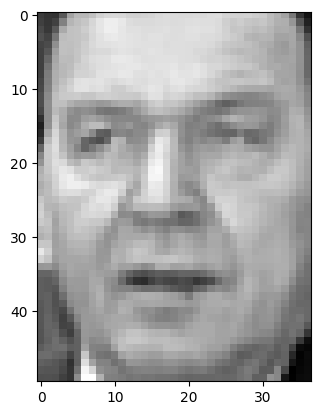

In [10]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

#**HoldOut evaluación**

- Se particiona el conjunto de datos en 80% para entrenamiento y 20% para evaluación.

In [11]:
# Partición 70/30
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, y, test_size=0.3, random_state=123, stratify=y)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
1015,0.001630,0.001661,0.001804,0.001902,0.001938,0.001984,0.002127,0.002194,0.002230,0.002302,...,0.001625,0.001728,0.002886,0.003568,0.003440,0.003204,0.002804,0.001646,0.000543,0.000410
106,0.000779,0.001077,0.001440,0.001707,0.001938,0.002215,0.002445,0.002553,0.002599,0.002686,...,0.002481,0.002548,0.002676,0.003055,0.003583,0.003804,0.003865,0.003886,0.003870,0.003850
105,0.001235,0.001374,0.001651,0.001666,0.001507,0.001543,0.001640,0.001738,0.001835,0.001943,...,0.001061,0.001241,0.001282,0.001415,0.002850,0.003409,0.003148,0.003142,0.003199,0.003142
849,0.001543,0.001866,0.002466,0.002727,0.002722,0.002609,0.002543,0.002548,0.002604,0.002640,...,0.002502,0.002358,0.003081,0.003660,0.003706,0.003686,0.002030,0.000559,0.000769,0.000851
812,0.001087,0.001358,0.001692,0.002061,0.002235,0.002466,0.002650,0.002671,0.002691,0.002748,...,0.001405,0.001635,0.001297,0.000272,0.000349,0.000420,0.000492,0.000559,0.000651,0.000672


#**3. Definir pipelines y espacios de búsqueda**

In [12]:
pipelines = [
    Pipeline([('nor', MinMaxScaler()), ('cla', LogisticRegression(max_iter=1000))]),
    Pipeline([('nor', MinMaxScaler()), ('cla', SGDClassifier(max_iter=1000))]),
    Pipeline([('nor', MinMaxScaler()), ('cla', SVC(probability=True))]),
    Pipeline([('nor', MinMaxScaler()), ('cla', RandomForestClassifier())]),
    Pipeline([('nor', MinMaxScaler()), ('cla', GaussianNB())]),
    Pipeline([('nor', MinMaxScaler()), ('cla', LinearDiscriminantAnalysis())]),
    Pipeline([('nor', MinMaxScaler()), ('cla', KNeighborsClassifier())])
]

search_spaces = [
    {'cla__C': Real(1e-3, 1e3, prior='log-uniform')},
    {'cla__alpha': Real(1e-4, 1e2, prior='log-uniform')},
    {'cla__C': Real(1, 1e4, prior='log-uniform'), 'cla__gamma': Real(1e-3, 10, prior='log-uniform')},
    {'cla__n_estimators': Integer(10, 200), 'cla__max_depth': Integer(1, 20), 'cla__max_features': Categorical(['sqrt', 'log2'])},
    {},
    {'cla__solver': Categorical(['svd'])},
    {'cla__n_neighbors': Integer(1, 20), 'cla__weights': Categorical(['uniform', 'distance']), 'cla__p': Integer(1, 2)}
]

label_models = ['Logistic', 'SGD', 'SVCrbf', 'RandomForest', 'NaiveBayes', 'LDA', 'KNN']


#**4. Optimización bayesiana y comparación**


🔍 Optimizando Logistic...

🔍 Optimizando SGD...

🔍 Optimizando SVCrbf...

🔍 Optimizando RandomForest...

🔍 Optimizando NaiveBayes...

🔍 Optimizando LDA...

🔍 Optimizando KNN...


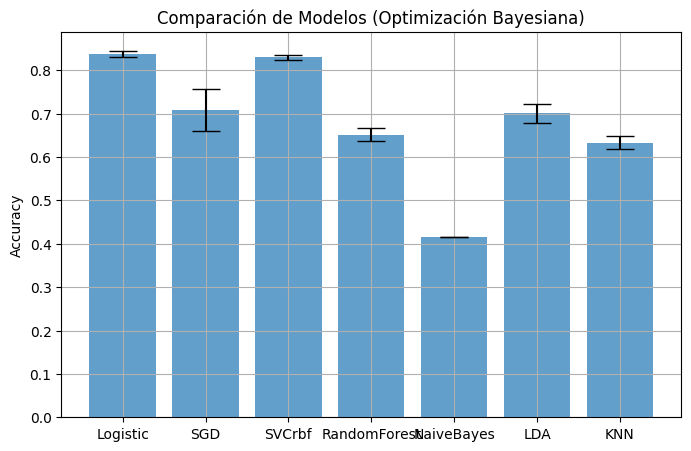

['modelos_bayes_7.pkl']

In [13]:
results = []
stds = []
models = []

for i, pipe in enumerate(pipelines):
    print(f"\n🔍 Optimizando {label_models[i]}...")

    if search_spaces[i]:
        opt = BayesSearchCV(pipe, search_spaces[i], n_iter=20, scoring='accuracy',
                            refit=True, cv=StratifiedKFold(5), n_jobs=-1, verbose=0)
        opt.fit(Xtrain, ytrain)
        best_model = opt
    else:
        pipe.fit(Xtrain, ytrain)
        best_model = pipe

    models.append(best_model)
    ypred = best_model.predict(Xtest)
    acc = accuracy_score(ytest, ypred)
    results.append(acc)

    if hasattr(best_model, 'cv_results_'):
        stds.append(best_model.cv_results_['std_test_score'][best_model.best_index_])
    else:
        stds.append(0.0)

# Visualización de barras
plt.figure(figsize=(8, 5))
plt.bar(np.arange(len(results)), results, yerr=stds, capsize=10, alpha=0.7)
plt.xticks(np.arange(len(label_models)), label_models)
plt.ylabel("Accuracy")
plt.title("Comparación de Modelos (Optimización Bayesiana)")
plt.grid(True)
plt.show()

# Guardar modelos
joblib.dump(models, 'modelos_bayes_7.pkl')


#**5: Funciones para evaluación final**

In [14]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.title(title)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

def roc_multiclass(y_true_bin, y_score):
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(y_true_bin.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return roc_auc, fpr, tpr

def plot_roc_multiclass(fpr, tpr, roc_auc, model_name):
    plt.figure(figsize=(10, 8))
    for i in range(len(roc_auc)):
        plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'Curva ROC - {model_name}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#**6. Evaluación final con matriz de confusión y ROC**


📌 Logistic - ACC: 0.837
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.65      0.75        23
     Colin Powell       0.88      0.86      0.87        71
  Donald Rumsfeld       0.72      0.78      0.75        37
    George W Bush       0.86      0.94      0.90       159
Gerhard Schroeder       0.81      0.67      0.73        33
      Hugo Chavez       0.93      0.62      0.74        21
       Tony Blair       0.74      0.81      0.78        43

         accuracy                           0.84       387
        macro avg       0.83      0.76      0.79       387
     weighted avg       0.84      0.84      0.83       387



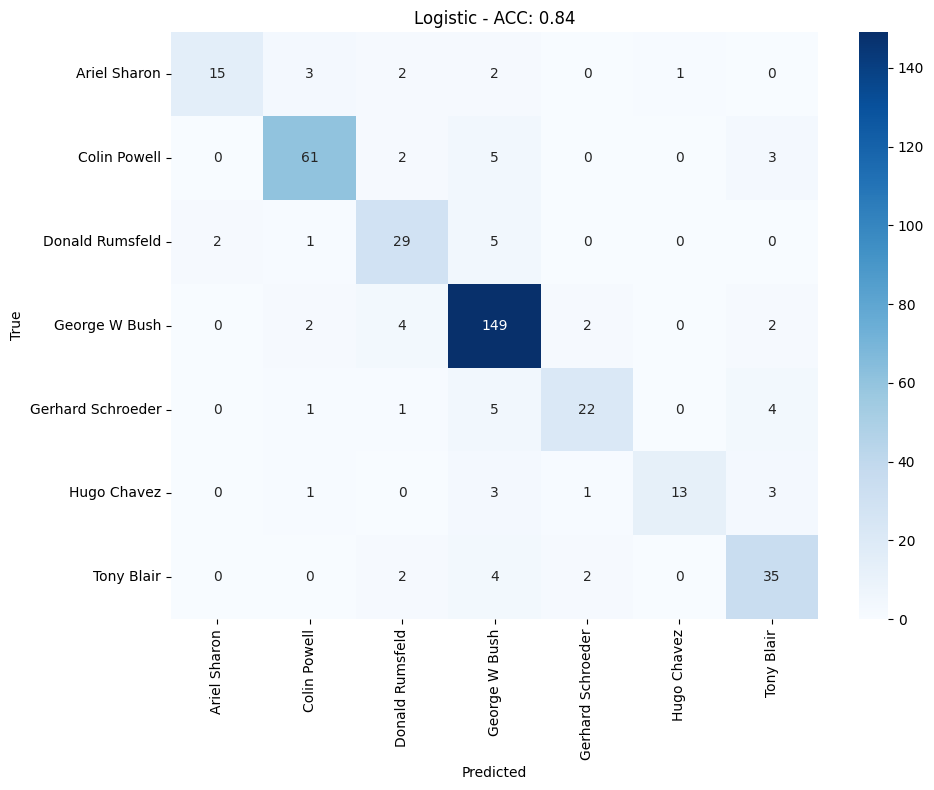

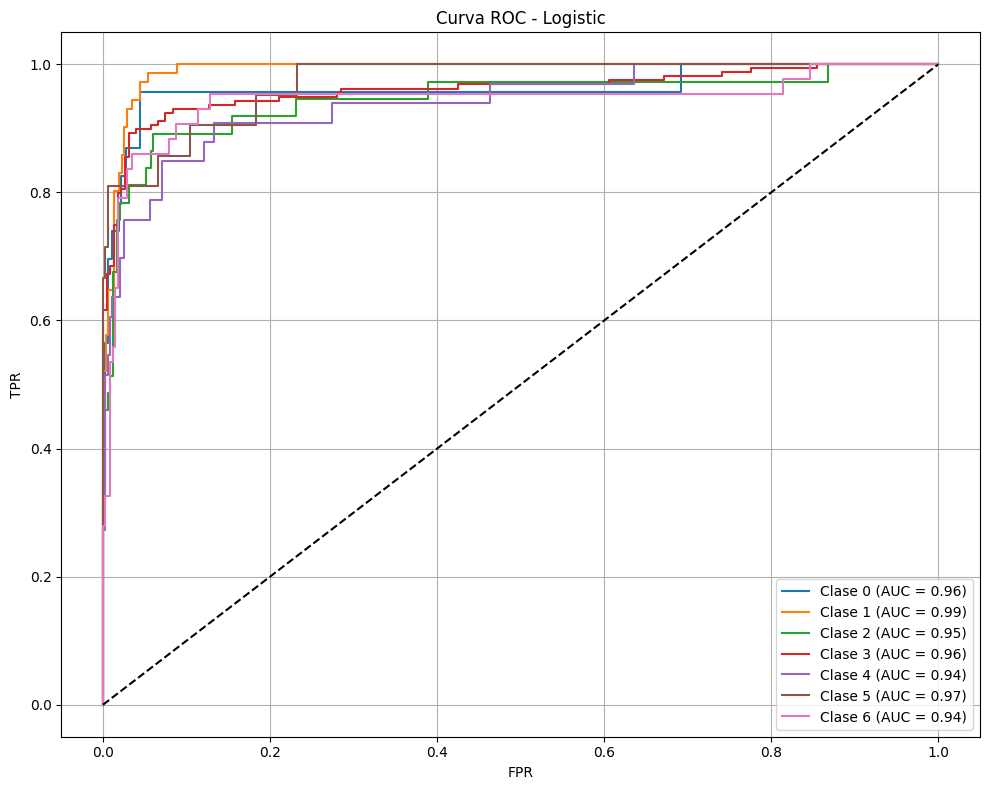


📌 SGD - ACC: 0.708
                   precision    recall  f1-score   support

     Ariel Sharon       0.74      0.61      0.67        23
     Colin Powell       1.00      0.37      0.54        71
  Donald Rumsfeld       0.73      0.65      0.69        37
    George W Bush       0.81      0.89      0.85       159
Gerhard Schroeder       0.92      0.36      0.52        33
      Hugo Chavez       0.88      0.71      0.79        21
       Tony Blair       0.39      0.95      0.56        43

         accuracy                           0.71       387
        macro avg       0.78      0.65      0.66       387
     weighted avg       0.80      0.71      0.70       387



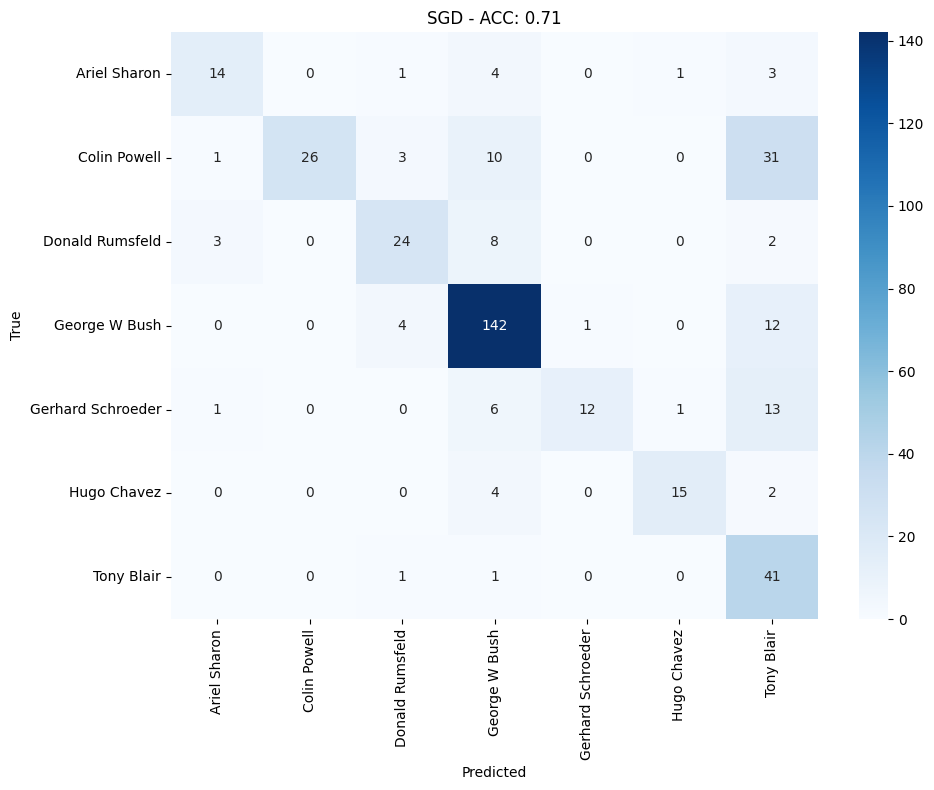

❌ No se pudo generar ROC para SGD: This 'Pipeline' has no attribute 'predict_proba'

📌 SVCrbf - ACC: 0.829
                   precision    recall  f1-score   support

     Ariel Sharon       0.68      0.74      0.71        23
     Colin Powell       0.85      0.89      0.87        71
  Donald Rumsfeld       0.75      0.65      0.70        37
    George W Bush       0.86      0.91      0.89       159
Gerhard Schroeder       0.78      0.64      0.70        33
      Hugo Chavez       0.94      0.71      0.81        21
       Tony Blair       0.80      0.84      0.82        43

         accuracy                           0.83       387
        macro avg       0.81      0.77      0.78       387
     weighted avg       0.83      0.83      0.83       387



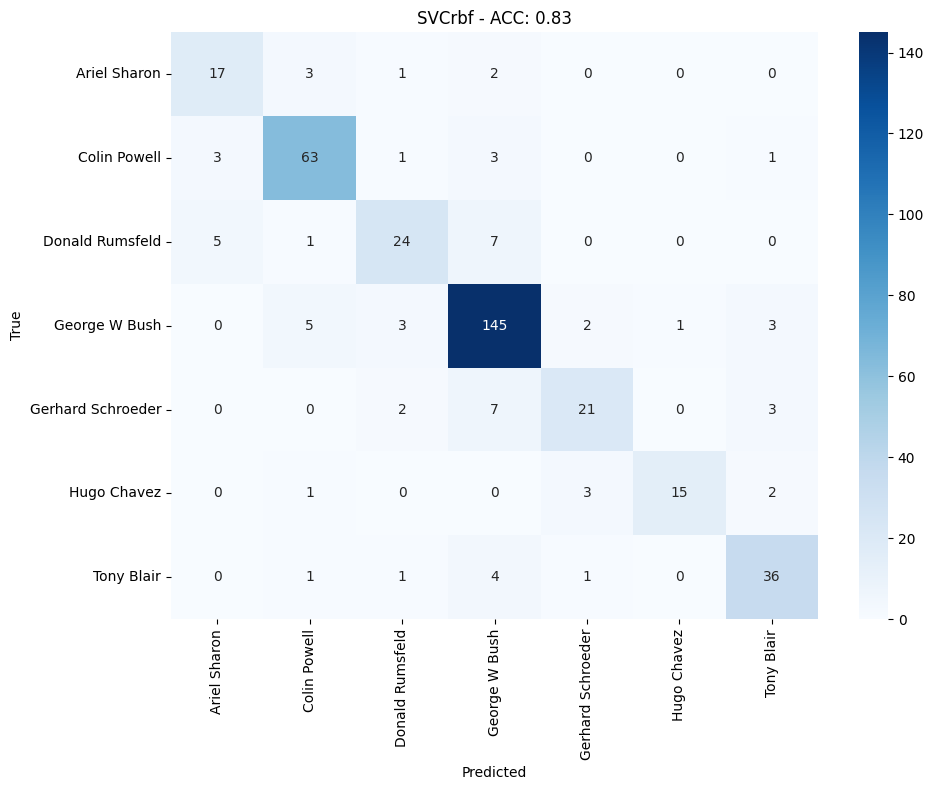

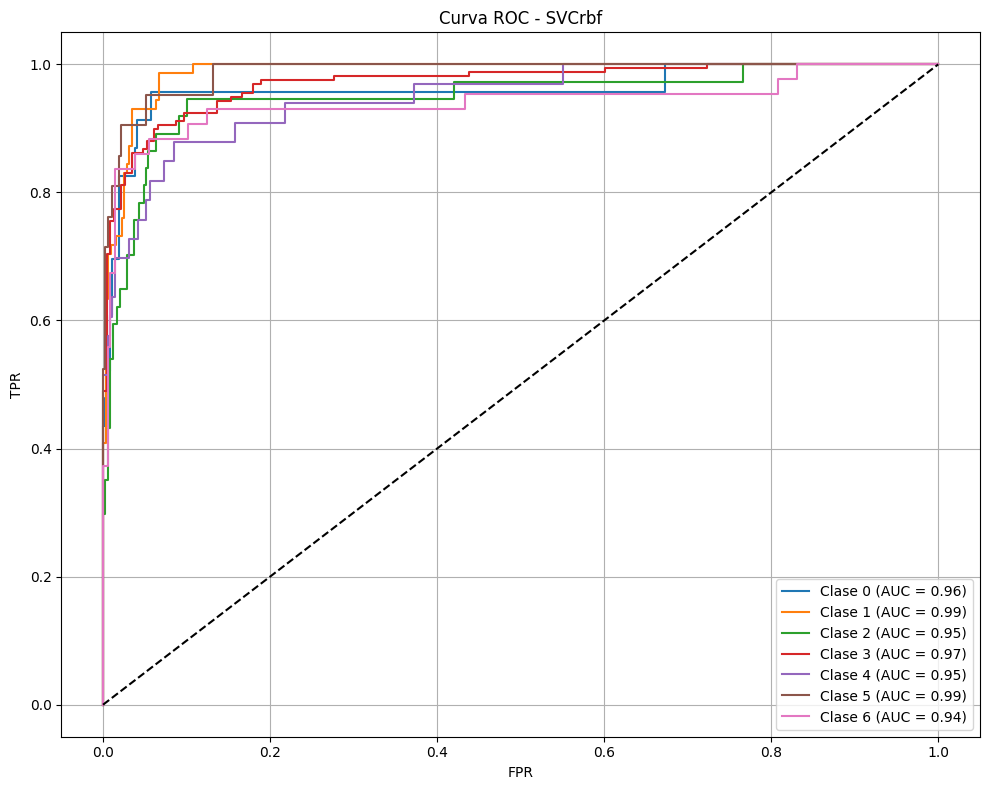


📌 RandomForest - ACC: 0.651
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.04      0.08        23
     Colin Powell       0.79      0.75      0.77        71
  Donald Rumsfeld       0.85      0.30      0.44        37
    George W Bush       0.59      0.97      0.73       159
Gerhard Schroeder       0.58      0.21      0.31        33
      Hugo Chavez       1.00      0.38      0.55        21
       Tony Blair       0.74      0.40      0.52        43

         accuracy                           0.65       387
        macro avg       0.79      0.44      0.49       387
     weighted avg       0.71      0.65      0.60       387



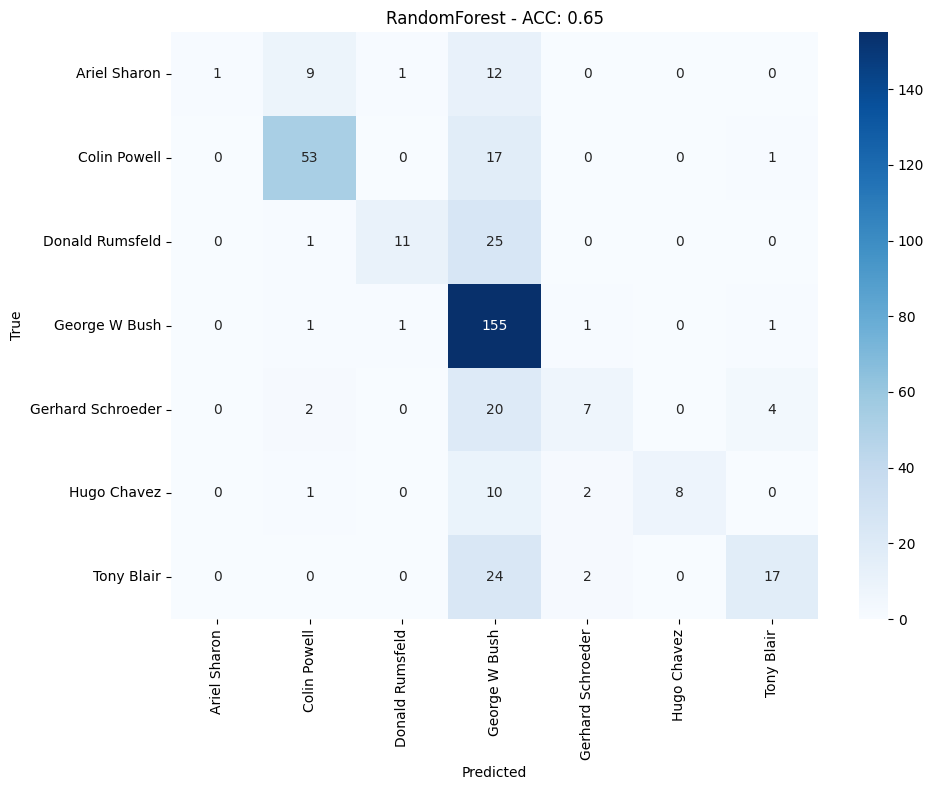

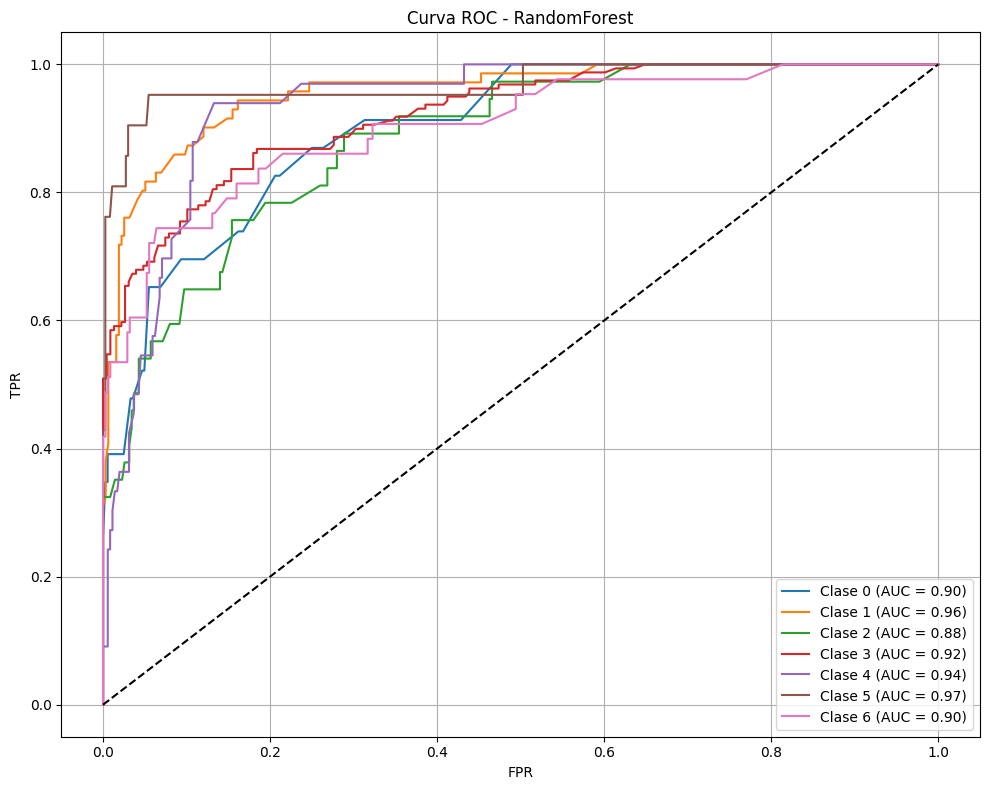


📌 NaiveBayes - ACC: 0.416
                   precision    recall  f1-score   support

     Ariel Sharon       0.33      0.43      0.38        23
     Colin Powell       0.51      0.51      0.51        71
  Donald Rumsfeld       0.47      0.49      0.48        37
    George W Bush       0.91      0.30      0.45       159
Gerhard Schroeder       0.17      0.33      0.23        33
      Hugo Chavez       0.23      0.71      0.35        21
       Tony Blair       0.33      0.53      0.41        43

         accuracy                           0.42       387
        macro avg       0.42      0.47      0.40       387
     weighted avg       0.60      0.42      0.43       387



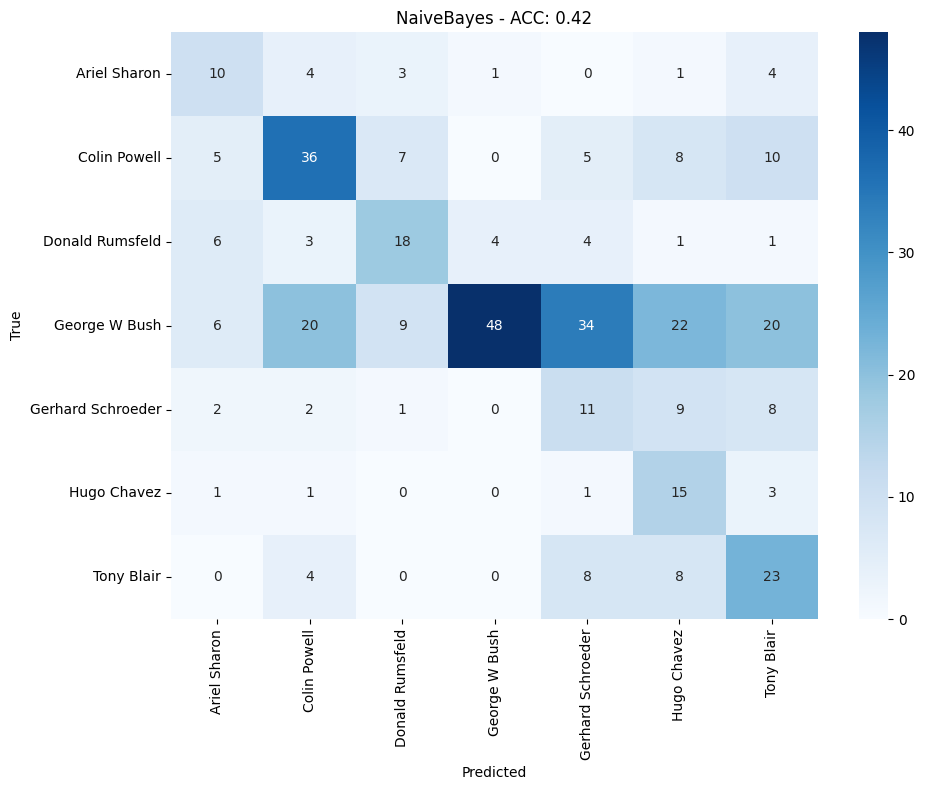

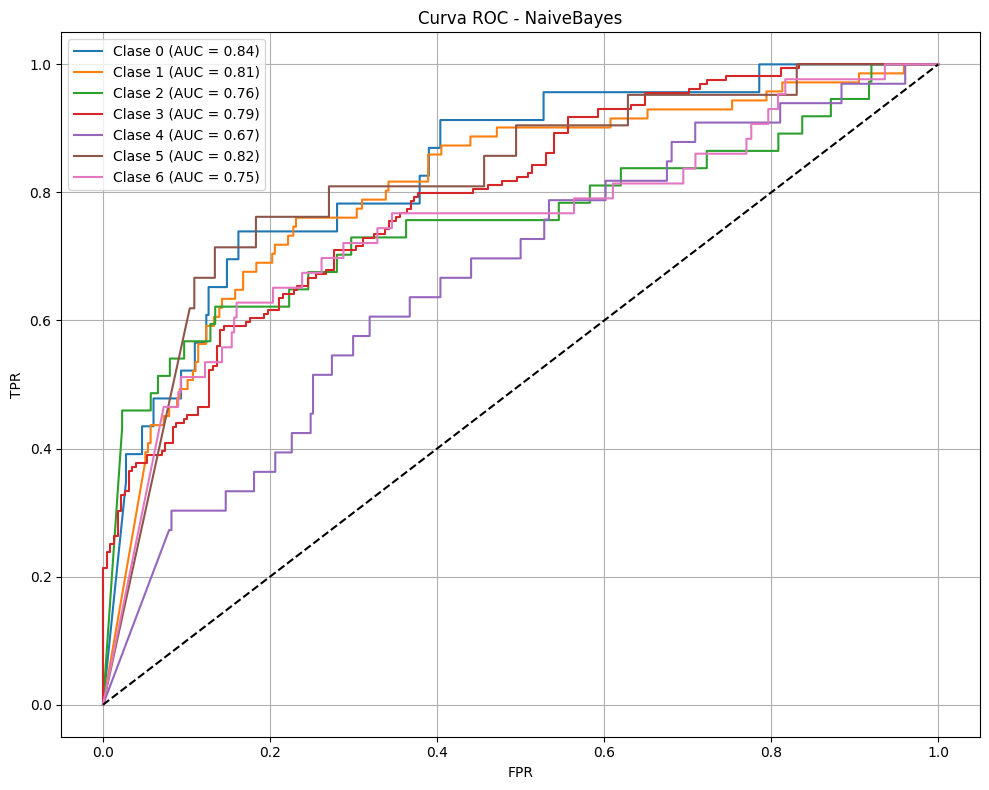


📌 LDA - ACC: 0.700
                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.39      0.50        23
     Colin Powell       0.73      0.68      0.70        71
  Donald Rumsfeld       0.56      0.65      0.60        37
    George W Bush       0.79      0.81      0.80       159
Gerhard Schroeder       0.54      0.58      0.56        33
      Hugo Chavez       0.58      0.71      0.64        21
       Tony Blair       0.68      0.63      0.65        43

         accuracy                           0.70       387
        macro avg       0.65      0.64      0.64       387
     weighted avg       0.70      0.70      0.70       387



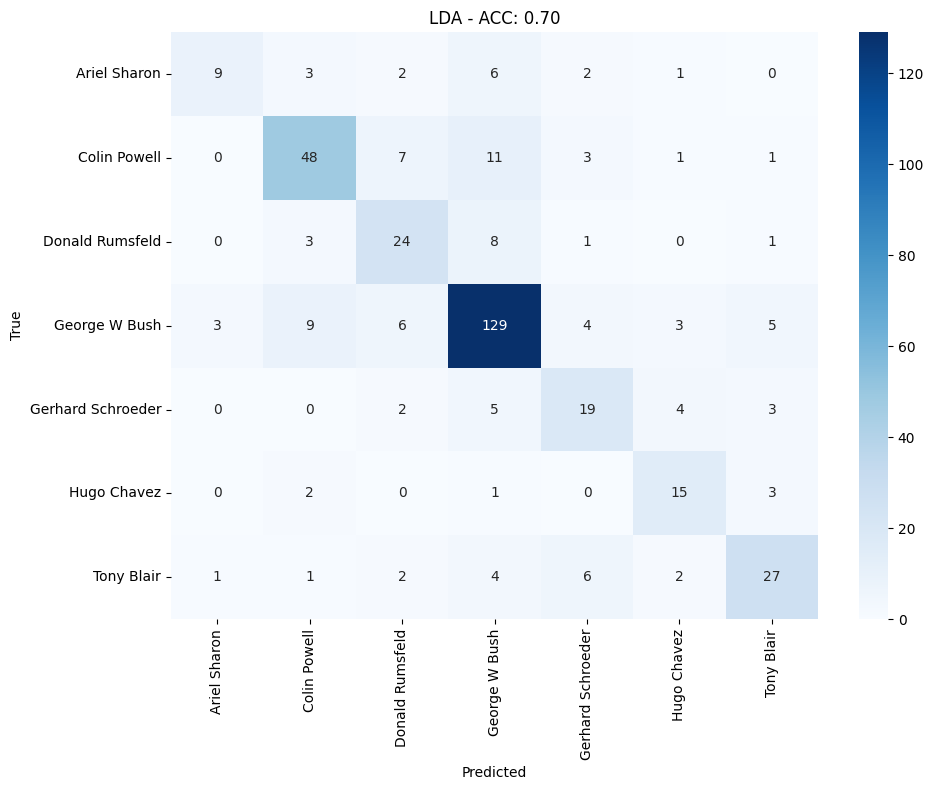

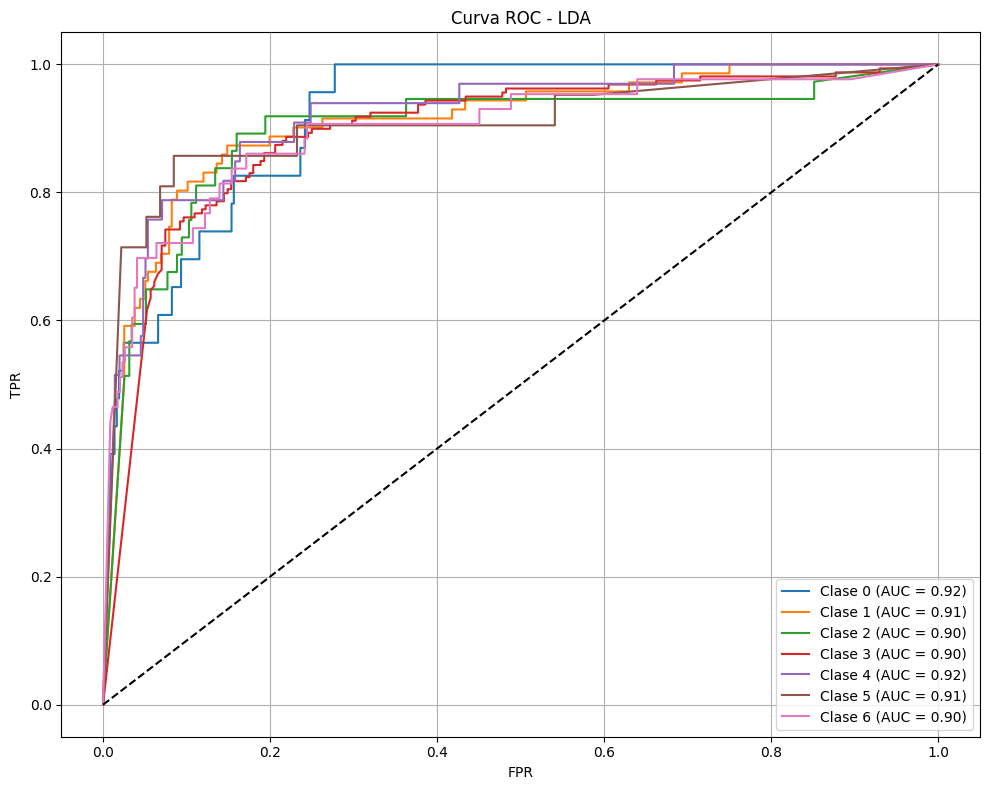


📌 KNN - ACC: 0.633
                   precision    recall  f1-score   support

     Ariel Sharon       0.80      0.35      0.48        23
     Colin Powell       0.58      0.66      0.62        71
  Donald Rumsfeld       0.68      0.41      0.51        37
    George W Bush       0.65      0.91      0.76       159
Gerhard Schroeder       0.43      0.27      0.33        33
      Hugo Chavez       0.75      0.14      0.24        21
       Tony Blair       0.72      0.42      0.53        43

         accuracy                           0.63       387
        macro avg       0.66      0.45      0.50       387
     weighted avg       0.64      0.63      0.60       387



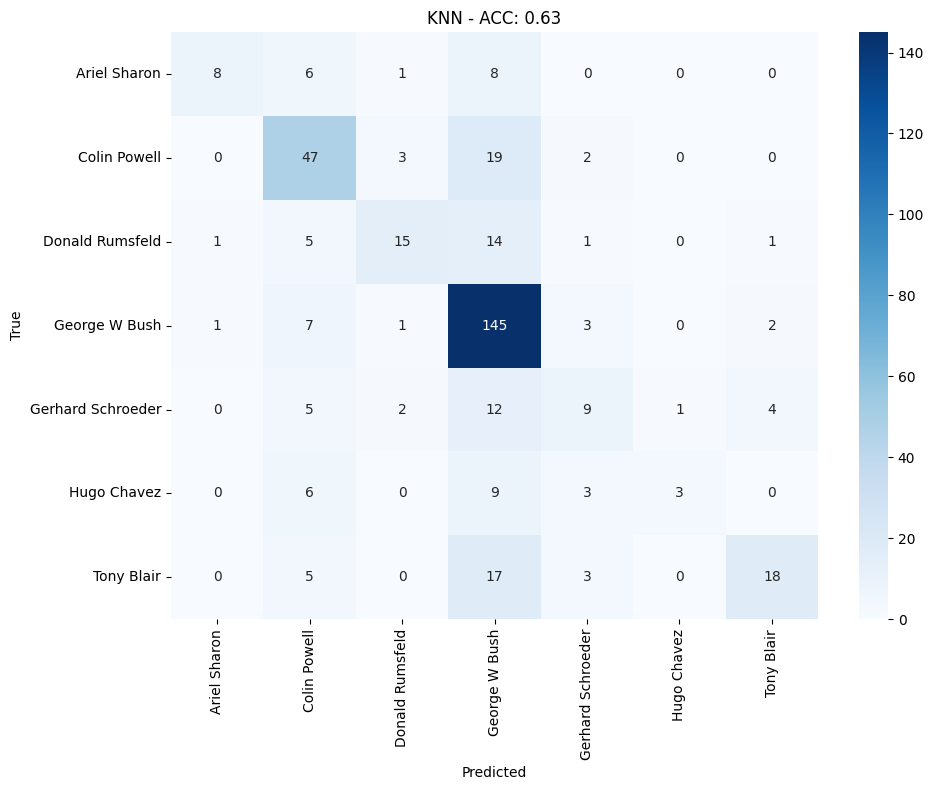

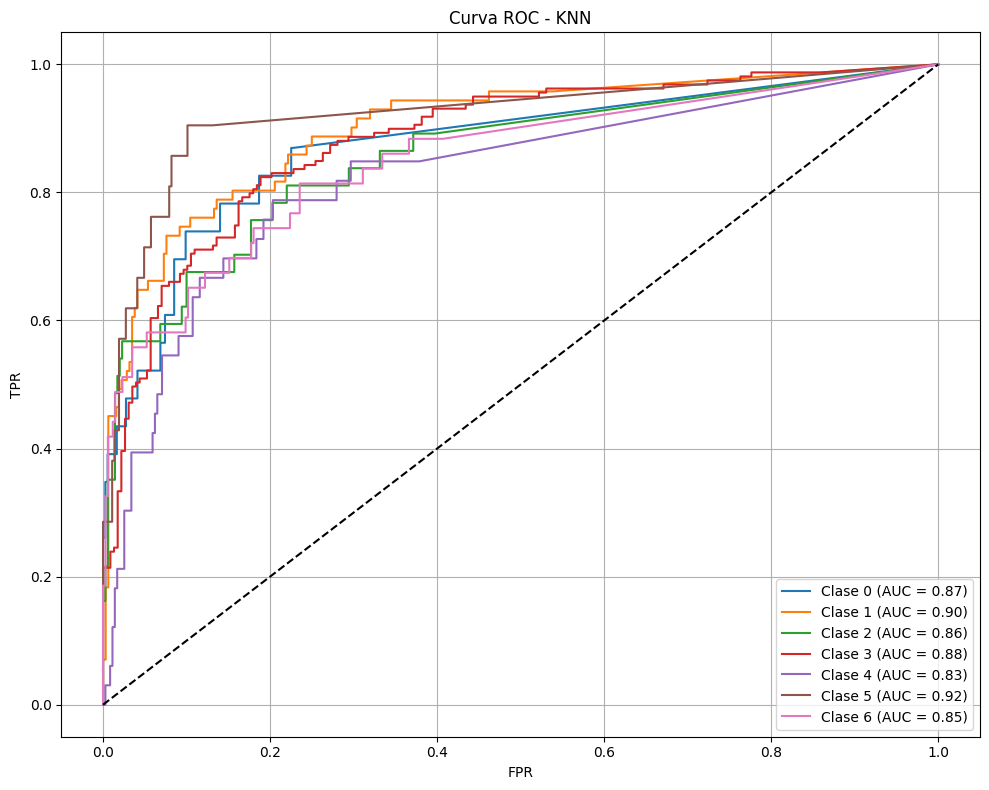

In [15]:
modelos_cargados = joblib.load('modelos_bayes_7.pkl')
ytest_bin = label_binarize(ytest, classes=np.unique(y))

for i, model in enumerate(modelos_cargados):
    name = label_models[i]
    est = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
    y_pred = est.predict(Xtest)
    acc = accuracy_score(ytest, y_pred)

    print(f"\n📌 {name} - ACC: {acc:.3f}")
    print(classification_report(ytest, y_pred, target_names=lfw_people.target_names))
    plot_confusion_matrix(ytest, y_pred, lfw_people.target_names, title=f"{name} - ACC: {acc:.2f}")

    try:
        y_score = est.predict_proba(Xtest)
        if y_score.shape[1] == ytest_bin.shape[1]:
            roc_auc, fpr, tpr = roc_multiclass(ytest_bin, y_score)
            plot_roc_multiclass(fpr, tpr, roc_auc, name)
        else:
            print("⚠️ Clases no coinciden, se omite curva ROC.")
    except Exception as e:
        print(f"❌ No se pudo generar ROC para {name}: {e}")


#**7. Generación de tabla comparativa de rendimiento para los 7 clasificadores clasicos**

In [16]:
from sklearn.metrics import f1_score, roc_auc_score

tabla_resultados = []

ytest_bin = label_binarize(ytest, classes=np.unique(y))

for i, model in enumerate(models):
    name = label_models[i]
    est = model.best_estimator_ if hasattr(model, 'best_estimator_') else model

    y_pred = est.predict(Xtest)
    acc = accuracy_score(ytest, y_pred)
    f1 = f1_score(ytest, y_pred, average='macro')

    try:
        y_score = est.predict_proba(Xtest)
        auc_score = roc_auc_score(ytest_bin, y_score, average='macro', multi_class='ovr')
    except:
        auc_score = np.nan

    tabla_resultados.append({
        'Modelo': name,
        'Accuracy': acc,
        'F1 Score': f1,
        'AUC Score': auc_score
    })

df_resultados = pd.DataFrame(tabla_resultados)
df_resultados = df_resultados.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
display(df_resultados)


,Modelo,Accuracy,F1 Score,AUC Score
0,Logistic,0.837209,0.789462,0.959088
1,SVCrbf,0.829457,0.784113,0.963449
2,SGD,0.708010,0.658257,NaN
3,LDA,0.700258,0.635316,0.907739
4,RandomForest,0.651163,0.486290,0.924044
5,KNN,0.633075,0.495953,0.873444
6,NaiveBayes,0.416021,0.401950,0.776425
